In [1]:
import time
import numpy as np
import torch

import src.utils as ut
from src.SCMMappings_1_1 import Abstraction
from src.printing import AbstractionPrinter

import matplotlib.pyplot as plt
from pgmpy.models import BayesianNetwork as BN
from pgmpy.factors.discrete import TabularCPD as cpd

In [2]:
seed = 0
np.random.seed(seed)  # Numpy module
torch.manual_seed(seed)

In [3]:
from src.examples import smokingmodels as ex

In [4]:
A_vstruct = Abstraction(*ex.vstruct_lung_cancer())


In [5]:
import src.evaluationsets as es
import src.learning as lng

In [6]:
freq_interv_vstruct = np.array([2.4,.3,.3])
J_vstruct = [[['Smoking_'], ['Cancer_']],
 [['Smoking_'], ['Fatigue_']],
 [['Cancer_'], ['Fatigue_']]]

In [7]:
from src.nn import JointNeuralNet
from src.nn_losses import JSD_loss,RowMax_penalty

In [8]:
def calc_distance(Ws, alpha_index, alphas):
    distance = 0.0
    for key, value in alphas.items():
        distance += torch.sum(torch.abs(torch.from_numpy(value)-Ws[alpha_index[key]]))
    return distance

In [9]:
def train_a_JointNN_model(M0,M1,R,a,alphas,J,weighted,T,lmbda,num_epochs,lr):
    distances = np.zeros((num_epochs))
    jsds = np.zeros((num_epochs))
    pens = np.zeros((num_epochs))
    end_results = {}
    
    
    model = JointNeuralNet(M0,M1,R,a,J,T)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion_jsd = JSD_loss()
    criterion_pen = RowMax_penalty()
    
    
    for epoch in range(num_epochs):
        lowpaths, highpaths, Ws = model()    
        loss_jsd = criterion_jsd(lowpaths, highpaths, weighted)
        loss_pen = criterion_pen(Ws)
        loss = lmbda*loss_jsd + loss_pen
        
        distances[epoch] = calc_distance(Ws, model.alpha_index, alphas)
        jsds[epoch] = loss_jsd
        pens[epoch] = loss_pen

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (epoch+1) % 500 == 0:
            print ('Epoch [{}/{}], Loss: {:.4f}, JSD: {:.4f}, Penalty: {:.4f}'.format(epoch+1, num_epochs, loss, loss_jsd, loss_pen))
    
    learnt_alphas = {}
    for name in model.alphas_to_learn:
        learnt_alphas[name] = model.get_Wmatrix_by_name(name).detach()
        
    # discretize alphas and calc_distance
    discretized_alphas = {}
    for name, value in learnt_alphas.items():
        tmp = torch.zeros((value.shape))
        for i in range(value.shape[1]):
            tmp[torch.argmax(value[:,i]),i] = 1
        discretized_alphas[name] = tmp
    
    #calculate distance with discrete learnt alphas
    end_distance = 0.0
    for key, value in alphas.items():
        end_distance += torch.sum(torch.abs(torch.from_numpy(alphas[key])-discretized_alphas[key]))
    
    # jsd and penalty with initalised discrete alphas
    criterion_jsd = JSD_loss()
    criterion_pen = RowMax_penalty()
    end_model = JointNeuralNet(M0,M1,R,a,J,T,initialised_alphas=discretized_alphas)
    lowpaths, highpaths, Ws = end_model()    
    end_loss_jsd = criterion_jsd(lowpaths, highpaths)
    end_loss_pen = criterion_pen(Ws)
    
    # store end results
    end_results['normalised_alphas'] = learnt_alphas
    end_results['discretized_alpha'] = discretized_alphas
    end_results['jsd'] = end_loss_jsd
    end_results['penalty'] = end_loss_pen
    end_results['distance'] = end_distance
    
    return distances/len(alphas), jsds/len(J), pens/len(alphas), end_results

In [10]:
lr = 0.01
num_epochs = 500
T = 0.1
lmbda=10.0
n_fold = 10
k_fold = 10

In [11]:

n_best_distance4 = np.zeros((n_fold,num_epochs))
n_best_jsd4 = np.zeros((n_fold,num_epochs))
n_best_pen4 = np.zeros((n_fold,num_epochs))
n_best_end_results4 = []
n_time4 = np.zeros((n_fold))


for n in range(n_fold):
    print(f"n fold {n+1}:")

    k_distances4 = np.zeros((k_fold,num_epochs))
    k_jsds4 = np.zeros((k_fold,num_epochs))
    k_pens4 = np.zeros((k_fold,num_epochs))
    k_end_results4 = []
    k_time4 = np.zeros((k_fold))
    
    for fold in range(k_fold):
        
        st = time.time()
        distances_epoch4, jsds4, pens4, end_results4 = train_a_JointNN_model(A_vstruct.M0, A_vstruct.M1, A_vstruct.R, A_vstruct.a, A_vstruct.alphas, J_vstruct,
                     weighted=freq_interv_vstruct, T=T, lmbda=lmbda, num_epochs=num_epochs, lr=lr)
        et = time.time()
        time4 = et - st
        
        k_distances4[fold] = distances_epoch4
        k_jsds4[fold] = jsds4
        k_pens4[fold] = pens4
        k_end_results4.append(end_results4)
        k_time4[fold] = time4
        
    k_losses4 = k_jsds4+k_pens4
    best4 = np.argmin(k_losses4[:,-1])
    
    n_best_distance4[n] = k_distances4[best4]
    n_best_jsd4[n] = k_jsds4[best4]
    n_best_pen4[n] = k_pens4[best4]
    n_best_end_results4.append(k_end_results4[best4])
    n_time4[n] = k_time4[best4]
        
        

n fold 1:
Epoch [500/500], Loss: 1.9214, JSD: 0.0077, Penalty: 1.8445
Epoch [500/500], Loss: 1.3477, JSD: 0.0502, Penalty: 0.8453
Epoch [500/500], Loss: 1.9354, JSD: 0.0099, Penalty: 1.8367
Epoch [500/500], Loss: 2.4642, JSD: 0.1123, Penalty: 1.3408
Epoch [500/500], Loss: 1.0400, JSD: 0.0063, Penalty: 0.9775
Epoch [500/500], Loss: 1.2891, JSD: 0.0426, Penalty: 0.8627
Epoch [500/500], Loss: 2.2768, JSD: 0.0952, Penalty: 1.3252
Epoch [500/500], Loss: 1.1906, JSD: 0.0339, Penalty: 0.8516
Epoch [500/500], Loss: 1.0261, JSD: 0.0039, Penalty: 0.9867
Epoch [500/500], Loss: 0.8263, JSD: 0.0055, Penalty: 0.7716
n fold 2:
Epoch [500/500], Loss: 1.4014, JSD: 0.0335, Penalty: 1.0666
Epoch [500/500], Loss: 1.3233, JSD: 0.0107, Penalty: 1.2163
Epoch [500/500], Loss: 1.1936, JSD: 0.0060, Penalty: 1.1336
Epoch [500/500], Loss: 1.3510, JSD: 0.0587, Penalty: 0.7637
Epoch [500/500], Loss: 1.2703, JSD: 0.0045, Penalty: 1.2252
Epoch [500/500], Loss: 1.3839, JSD: 0.0411, Penalty: 0.9728
Epoch [500/500], Los

In [12]:

avg_dis4 = np.mean(n_best_distance4,axis=0)
avg_dis_err4 = np.std(n_best_distance4,axis=0)

avg_jsd4 = np.mean(n_best_jsd4,axis=0)
avg_jsd_err4 = np.std(n_best_jsd4,axis=0)

avg_pen4 = np.mean(n_best_pen4,axis=0)
avg_pen_err4 = np.std(n_best_pen4,axis=0)

avg_time4 = np.mean(n_time4,axis=0)
avg_time_err4 = np.std(n_time4,axis=0)

print(f"Vstruct: Avg Alpha distance: {avg_dis4[-1]}")
print(f"Vstruct: Avg JSD: {avg_jsd4[-1]}")
print(f"Vstruct: Avg Penalty: {avg_pen4[-1]}")
print(f"Vstruct: Avg Time: {avg_time4}")
print(f"Vstruct: Avg Alpha distance SD: {avg_dis_err4[-1]}")
print(f"Vstruct: Avg JSD SD: {avg_jsd_err4[-1]}")
print(f"Vstruct: Avg Penalty SD: {avg_pen_err4[-1]}")
print(f"Vstruct: Avg Time SD: {avg_time_err4}")

Vstruct: Avg Alpha distance: 1.305538781483968
Vstruct: Avg JSD: 0.003982562928770979
Vstruct: Avg Penalty: 0.25405189792315164
Vstruct: Avg Time: 0.5465210914611817
Vstruct: Avg Alpha distance SD: 0.5356910009961974
Vstruct: Avg JSD SD: 0.0029154619816588972
Vstruct: Avg Penalty SD: 0.006837770238928254
Vstruct: Avg Time SD: 0.014301843927372108


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


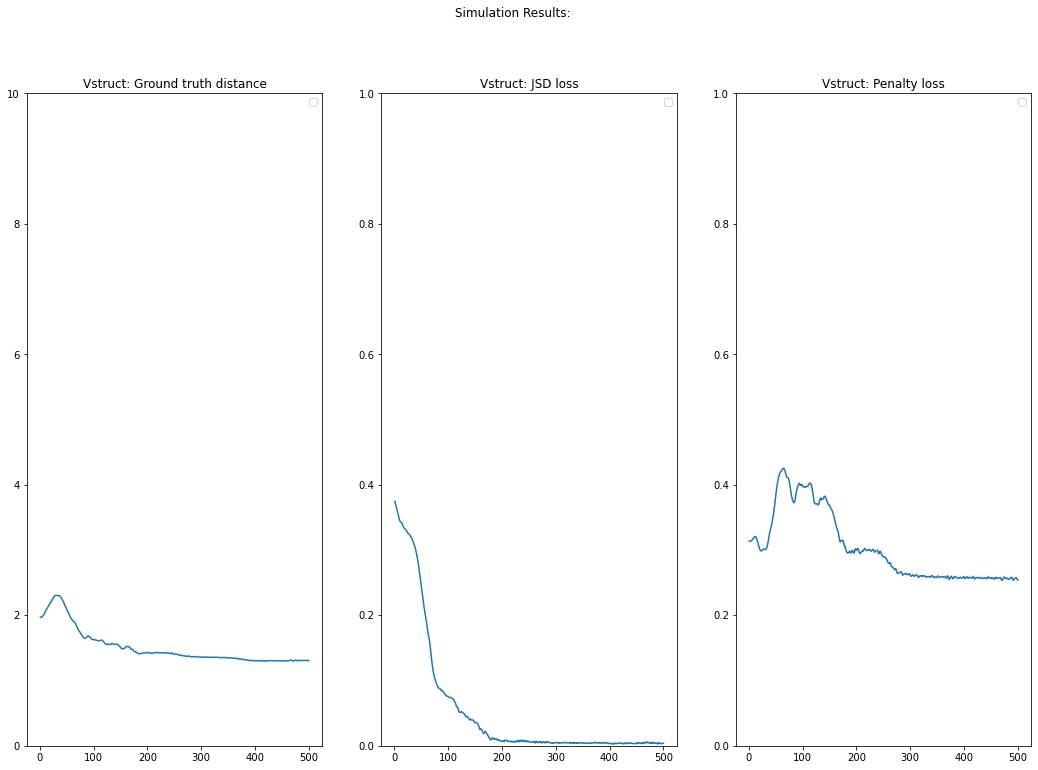

In [13]:

fig, ((ax0, ax1, ax2)) = plt.subplots(nrows=1, ncols=3, sharex=True,
                                    figsize=(18, 12))
time_epoch = np.array([i+1 for i in range(num_epochs)])
ax0.set_title('Vstruct: Ground truth distance')
ax0.plot(time_epoch, avg_dis4)
ax0.set_ylim([0,10])
ax0.legend()

ax1.set_title('Vstruct: JSD loss')
ax1.plot(time_epoch, avg_jsd4)
ax1.set_ylim([0,1])
ax1.legend()

ax2.set_title('Vstruct: Penalty loss')
ax2.plot(time_epoch, avg_pen4)
ax2.set_ylim([0,1])
ax2.legend()

fig.suptitle('Simulation Results:')
plt.show()

In [14]:
# Save results
np.save('./results/synthetic/b/avg-best-distance-app3-weighted-vstruct', n_best_distance4)
np.save('./results/synthetic/b/avg-best-JSD-app3-weighted-vstruct', n_best_jsd4)
np.save('./results/synthetic/b/avg-best-penalty-weighted-app3-vstruct', n_best_pen4)
np.save('./results/synthetic/b/avg-best-time-app3-weighted-vstruct', n_time4)
np.save('./results/synthetic/b/avg-best-endresults-app3-weighted-vstruct', n_best_end_results4)